In [11]:
import argparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
!pip install pmdarima
from sklearn.metrics import mean_squared_error as MSE
from pmdarima.arima import auto_arima


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def plot(input_file, whether_plot_trend, whether_plot_acf, whether_plot_seasonal_acf, diff):
    
# read in data
    
    df = pd.read_csv(input_file)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
#     print(df)

    if whether_plot_trend == True:
        plt.figure(figsize=(15,4))
        plt.plot(df.cost)
        plt.title('Project A Cost over Time') # fontsize=#
        plt.ylabel('Cost')
        for month in range(1,12):
            plt.axvline(pd.to_datetime('2022-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2) 
        n_diff = df.cost.diff()[1:]
        plt.figure(figsize=(15,4))
        plt.plot(n_diff)
        plt.title('Project A Stablized Cost over Time') # fontsize=#
        plt.ylabel('Cost')
        for month in range(1,12):
            plt.axvline(pd.to_datetime('2022-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)             
    
    if whether_plot_acf == True:
# acf
        acf_plot = plot_acf(df.cost, lags=40)
# pacf
        pacf_plot = plot_pacf(df.cost, lags=40)

# adfuller
        adfuller_result = adfuller(df.cost)
        print('ADF Statistic: %f' % adfuller_result[0])
        print('p-value: %f' % adfuller_result[1])

      #繪製標準差
        rolling_deviations = pd.Series(dtype=float, index = df.index)
        rolling_deviations_fake = pd.Series(dtype=float, index = df.index)
        for date in rolling_deviations.index:
            #get the window ending at this data point
            window = df.loc[date - timedelta(days=5):date]


            #get the deviation within this window
            rolling_deviations[date] = window.std()
            if rolling_deviations[date] > 20:
              df.loc[date] = np.mean(df.loc[date - timedelta(days=5):date])
              print(df.loc[date])
        #get the difference in deviation between one time point and the next
        diff_rolling_deviations = rolling_deviations
        diff_rolling_deviations = diff_rolling_deviations.dropna()
        plt.figure(figsize=(10,4))
        plt.plot(diff_rolling_deviations)
        plt.title('Deviation Differences', fontsize=20)
        plt.ylabel('usage', fontsize=16)





# stablized
    n_diff = []
    # n_diff = df.cost.diff()[1:]

    for i in range(diff, len(df.cost)):
        n_diff.append(df.cost[i] - df.cost[i-30])
        
    adfuller_result = adfuller(n_diff)
    print('ADF Statistic: %f' % adfuller_result[0])
    print('p-value: %f' % adfuller_result[1])
    if whether_plot_seasonal_acf == True:
# acf after removing trend
        acf_plot = plot_acf(n_diff, lags=40)
# pacf after removing trend
        pacf_plot = plot_pacf(n_diff, lags=40)


/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


ADF Statistic: -6.989692
p-value: 0.000000
nan
19.193583431947754
18.32671998306805
16.832427486447898
16.027538326104526
15.972340178478492
14.657391737391556
13.98259209919706
13.12169687903755
13.002900913613848
12.721440399749483
8.043989320354886
32.431602767748636
32.35973588091205
32.21925047125931
32.03282844343912
31.824502451031602
32.11856975718064
32.28566527992218
32.395028589178025
32.128794227988834
31.857470285745016
31.252681124419833
7.08169398908986
7.07994310067389
6.753726477728051
70.50736587164849
98.48124140288878
114.92417564827605
124.47959678246762
128.74765589787475
122.92589383122596
121.06994963532983
117.83371509548492
114.31892543047262
111.04535501594177
110.40102423666927
112.76645395754356
108.22736812626835
97.70734555914129
79.04940757193944
41.967815469781904
13.821900293568502
13.062921787493764
11.948259682661071
9.713962332658292
6.38591863102802
5.654262425269925
5.826126675560452
6.399963126434053
6.485298206935508
6.695195971189461
6.74264711

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


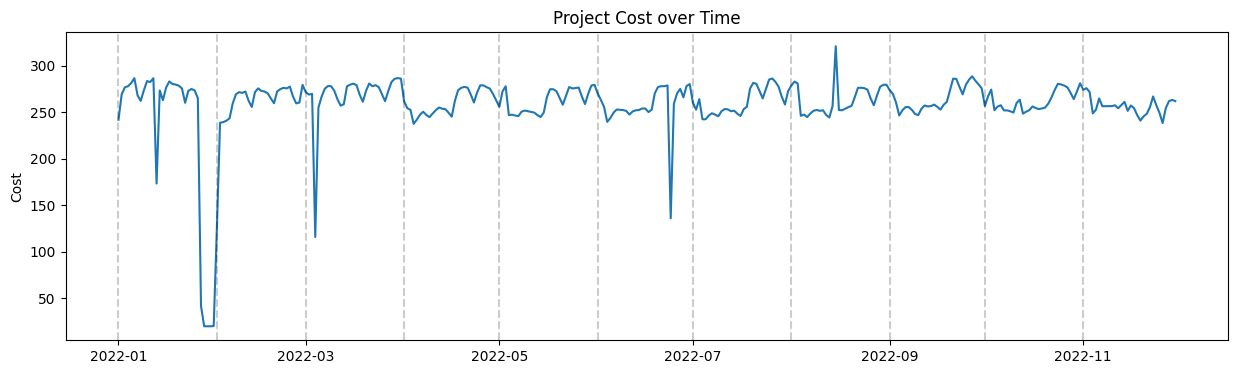

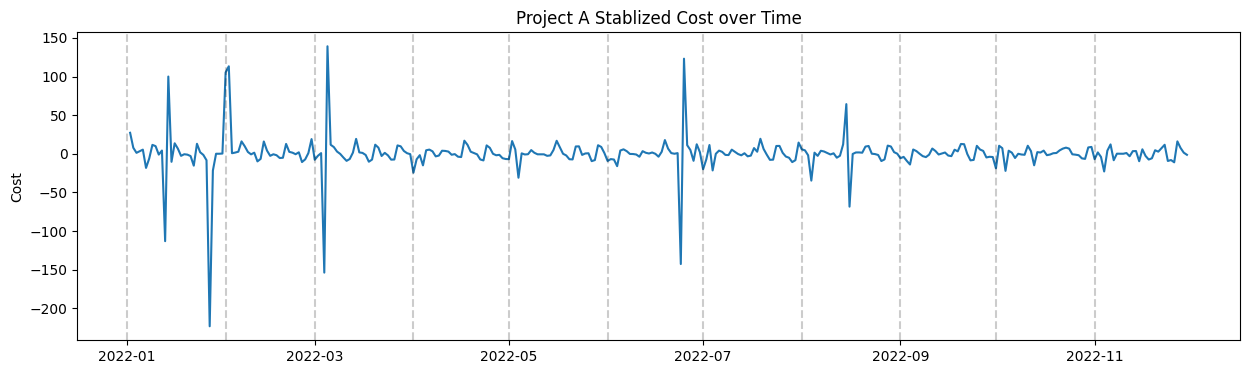

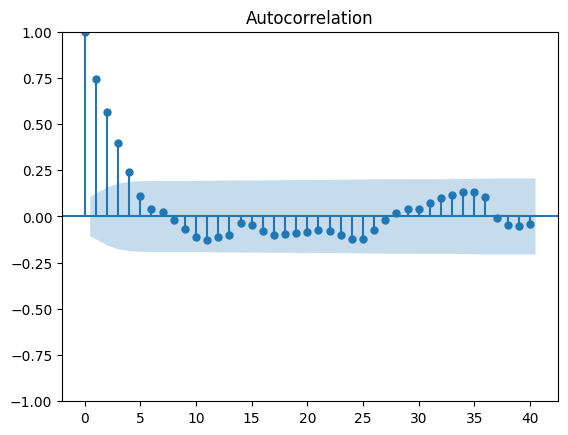

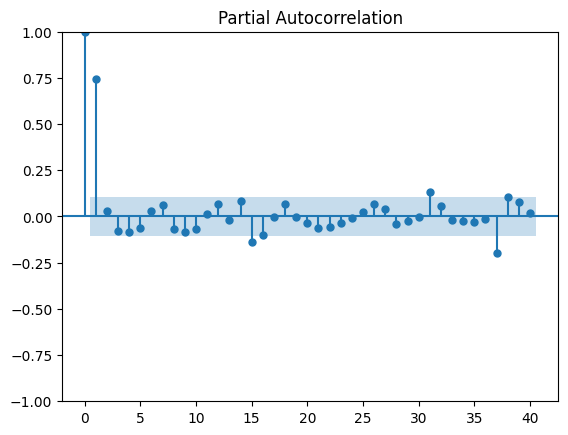

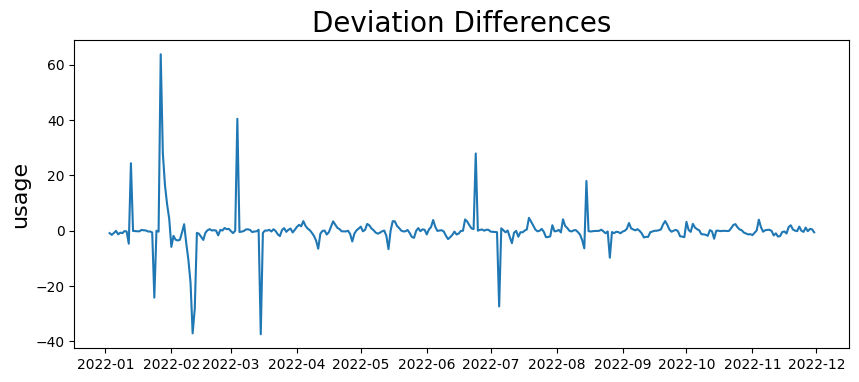

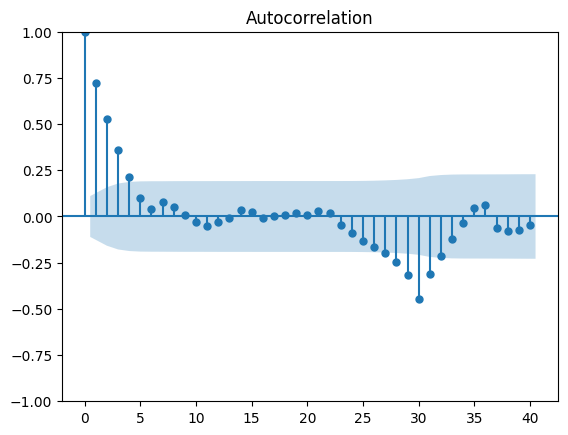

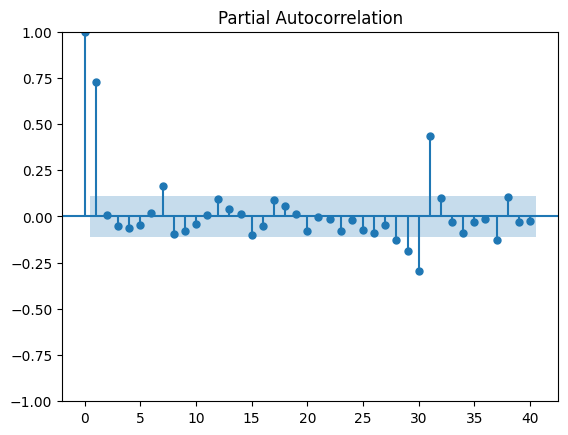

In [ ]:
if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--project', default='a')
#     parser.add_argument('--plot', default=True)
#     args = parser.parse_args()
#     main(args.input)

    project = 'a'
    whether_plot_trend = True
    whether_plot_acf = True
    whether_plot_seasonal_acf = True
    whether_take_diff = True # b needs to be taken
    diff = 20
    draw('project_a.csv', whether_plot_trend, whether_plot_acf, whether_plot_seasonal_acf,diff)

In [ ]:

def sarima_model(input_file, model_type, para):
    
# read in data
    
    df = pd.read_csv(input_file)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df2 = df.copy()
    #print(df)
    #print(df2)

    rolling_deviations = pd.Series(dtype=float, index = df.index)
    rolling_deviations_fake = pd.Series(dtype=float, index = df.index)
    for date in rolling_deviations.index:
        #get the window ending at this data point
        window = df2.loc[date - timedelta(days=5):date]


        #get the deviation within this window
        rolling_deviations[date] = window.std()
        if rolling_deviations[date] > 10:
              df2.loc[date] = np.mean(df2.loc[date - timedelta(days=5):date])
        

# train_test_split
    train_end = datetime(2022, 11, 1)
    val_end = datetime(2022, 11, 1)
    test_end = datetime(2022, 12, 1)
    
    train_data = df2[:train_end]
    val_data = df2[train_end+timedelta(days=1):val_end]
    test_data = df[val_end+timedelta(days=1):test_end]


# construct model
    best_RMSE = 1000
    best_para = []
    if model_type == 'arima':
        model = ARIMA(train_data, order=(para[0][0], para[0][1], para[0][2]))
        model_fit = model.fit()
        # print(model_fit.summary())
        
    if model_type == 'sarima':
        model = SARIMAX(train_data, order=(para[0][0], para[0][1], para[0][2]), seasonal_order=(para[1][0], para[1][1], para[1][2], para[1][3]))
        model_fit = model.fit()
        # print(model_fit.summary())
        
    if model_type == 'auto_sarima':
        Arima_model=auto_arima(train_data, start_p=1, start_q=1, max_p=10, max_q=2, start_P=7, start_Q=0,max_order = 10, max_P=10, max_Q=5, m=15, seasonal=True, trace=True, d=0, D=1 ,max_d = 1, max_D = 1,error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)
        Arima_model.summary()
        forecast_values, forecast_conf_int = Arima_model.forecast(len(test_data))
# predict test data
    
    best_model = SARIMAX(train_data, order=(para[0][0], para[0][1], para[0][2]), seasonal_order=(para[1][0], para[1][1], para[1][2], para[1][3]))
    best_model_fit = best_model.fit()
    
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    
    predictions = pd.DataFrame(best_model_fit.predict(start=pred_start_date, end=pred_end_date))
    predictions = predictions.rename(columns={'predicted_mean': 'cost'})
    predictions.index.name = 'date'
    residuals = test_data - predictions
    print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))
    
# plot residuals
    plt.figure(figsize=(15,4))
    plt.plot(residuals)
    plt.title('Residuals from Model') # fontsize=#
    plt.ylabel('Error')
    plt.axhline(0, color='r', linestyle='--', alpha=0.2)

# ground truth vs. prediction
    plt.figure(figsize=(15,4))
    plt.plot(test_data)
    plt.plot(predictions)

    plt.legend(('Data', 'Predictions'))

    plt.title('Project Cost over Time')
    plt.ylabel('Cost')

# # rolling prediction
    origin_data = test_data.copy()
    rolling_predictions = predictions.copy()
    # 計算train_data中所有的deviation
    for train_end in rolling_predictions.index:
        train_data = df2[:train_end-timedelta(days=1)]


        model = SARIMAX(train_data, order=(para[0][0], para[0][1], para[0][2]), seasonal_order=(para[1][0], para[1][1], para[1][2], para[1][3]))
        model_fit = model.fit()

        pred = model_fit.forecast()
        rolling_predictions[rolling_predictions.index == train_end] = pred

    rolling_residuals = origin_data - rolling_predictions
    print('Test Root Mean Squared Error (Rolling Forecasting):', np.sqrt(np.mean(rolling_residuals**2)))

    plt.figure(figsize=(15,4))
    plt.plot(origin_data)
    plt.plot(rolling_predictions)

    plt.legend(('Data', 'Predictions'))

    plt.title('rolling base Project Cost over Time')
    plt.ylabel('Cost')

In [ ]:
project = 'a'
model_type = 'auto_sarima'
para = [[1,0,0], [5, 1, 0, 7]] # arima:[[ar, i, ma]], sarima:[[ar, i, ma], [sar, si, sma, s]] 1,1,1,31

sarima_model('project_a.csv', model_type, para)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(7,1,0)[15] intercept   : AIC=1979.530, Time=67.56 sec
 ARIMA(0,0,0)(0,1,0)[15] intercept   : AIC=2523.082, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[15] intercept   : AIC=2052.562, Time=0.53 sec
 ARIMA(0,0,1)(0,1,1)[15] intercept   : AIC=inf, Time=1.73 sec
 ARIMA(0,0,0)(0,1,0)[15]             : AIC=2521.175, Time=0.04 sec
 ARIMA(1,0,1)(6,1,0)[15] intercept   : AIC=1989.493, Time=38.99 sec
 ARIMA(1,0,1)(8,1,0)[15] intercept   : AIC=1980.531, Time=92.70 sec
 ARIMA(1,0,1)(7,1,1)[15] intercept   : AIC=1980.597, Time=54.56 sec
 ARIMA(1,0,1)(6,1,1)[15] intercept   : AIC=inf, Time=45.03 sec
 ARIMA(1,0,1)(8,1,1)[15] intercept   : AIC=inf, Time=111.94 sec
 ARIMA(0,0,1)(7,1,0)[15] intercept   : AIC=2165.940, Time=54.19 sec
 ARIMA(1,0,0)(7,1,0)[15] intercept   : AIC=inf, Time=48.46 sec
 ARIMA(2,0,1)(7,1,0)[15] intercept   : AIC=1980.914, Time=67.38 sec
 ARIMA(1,0,2)(7,1,0)[15] intercept   : AIC=1980.590, Time=72.99 sec
 ARIMA(0,0,0)(7,1,0)[15] int

In [ ]:

def sarima_model(input_file, model_type, para):
    
# read in data
    
    df = pd.read_csv(input_file)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df2 = df.copy()
    #print(df)
    #print(df2)

    rolling_deviations = pd.Series(dtype=float, index = df.index)
    rolling_deviations_fake = pd.Series(dtype=float, index = df.index)
    for date in rolling_deviations.index:
        #get the window ending at this data point
        window = df2.loc[date - timedelta(days=5):date]


        #get the deviation within this window
        rolling_deviations[date] = window.std()
        if rolling_deviations[date] > 10:
              df2.loc[date] = np.mean(df2.loc[date - timedelta(days=5):date])
        

# train_test_split
    train_end = datetime(2022, 10, 16)
    val_end = datetime(2022, 10, 16)
    test_end = datetime(2022, 12, 1)
    
    train_data = df2[:train_end]
    val_data = df2[train_end+timedelta(days=1):val_end]
    test_data = df[val_end+timedelta(days=1):test_end]


# construct model
    best_RMSE = 1000
    best_para = []
    if model_type == 'arima':
        model = ARIMA(train_data, order=(para[0][0], para[0][1], para[0][2]))
        model_fit = model.fit()
        # print(model_fit.summary())
        
    if model_type == 'sarima':
        model = SARIMAX(train_data, order=(para[0][0], para[0][1], para[0][2]), seasonal_order=(para[1][0], para[1][1], para[1][2], para[1][3]))
        model_fit = model.fit()
        # print(model_fit.summary())
        
    if model_type == 'auto_sarima':
        Arima_model=auto_arima(train_data, start_p=1, start_q=1, max_p=10, max_q=2, start_P=7, start_Q=0,max_order = 10, max_P=10, max_Q=5, m=15, seasonal=True, trace=True, d=0, D=1 ,max_d = 1, max_D = 1,error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)
        Arima_model.summary()
        forecast_values, forecast_conf_int = Arima_model.forecast(len(test_data))
# predict test data
    
    best_model = SARIMAX(train_data, order=(para[0][0], para[0][1], para[0][2]), seasonal_order=(para[1][0], para[1][1], para[1][2], para[1][3]))
    best_model_fit = best_model.fit()
    
    pred_start_date = test_data.index[0]
    pred_end_date = test_data.index[-1]
    
    predictions = pd.DataFrame(best_model_fit.predict(start=pred_start_date, end=pred_end_date))
    predictions = predictions.rename(columns={'predicted_mean': 'cost'})
    predictions.index.name = 'date'
    residuals = test_data - predictions
    print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))
    
# plot residuals
    plt.figure(figsize=(15,4))
    plt.plot(residuals)
    plt.title('Residuals from Model') # fontsize=#
    plt.ylabel('Error')
    plt.axhline(0, color='r', linestyle='--', alpha=0.2)

# ground truth vs. prediction
    plt.figure(figsize=(15,4))
    plt.plot(test_data)
    plt.plot(predictions)

    plt.legend(('Data', 'Predictions'))

    plt.title('Project Cost over Time')
    plt.ylabel('Cost')

# # rolling prediction
    origin_data = test_data.copy()
    rolling_predictions = predictions.copy()

    for train_end in rolling_predictions.index:
        train_data = df2[train_end-timedelta(days=60):train_end-timedelta(days=1)]


        model = SARIMAX(train_data, order=(para[0][0], para[0][1], para[0][2]), seasonal_order=(para[1][0], para[1][1], para[1][2], para[1][3]))
        model_fit = model.fit()

        pred = model_fit.forecast()
        rolling_predictions[rolling_predictions.index == train_end] = pred

    rolling_residuals = origin_data - rolling_predictions
    print('Test Root Mean Squared Error (Rolling Forecasting):', np.sqrt(np.mean(rolling_residuals**2)))

    plt.figure(figsize=(15,4))
    plt.plot(origin_data)
    plt.plot(rolling_predictions)

    plt.legend(('Data', 'Predictions'))

    plt.title('rolling base Project Cost over Time')
    plt.ylabel('Cost')

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

Root Mean Squared Error: cost    9.59419
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Test Root Mean Squared Error (Rolling Forecasting): cost    7.653304
dtype: float64


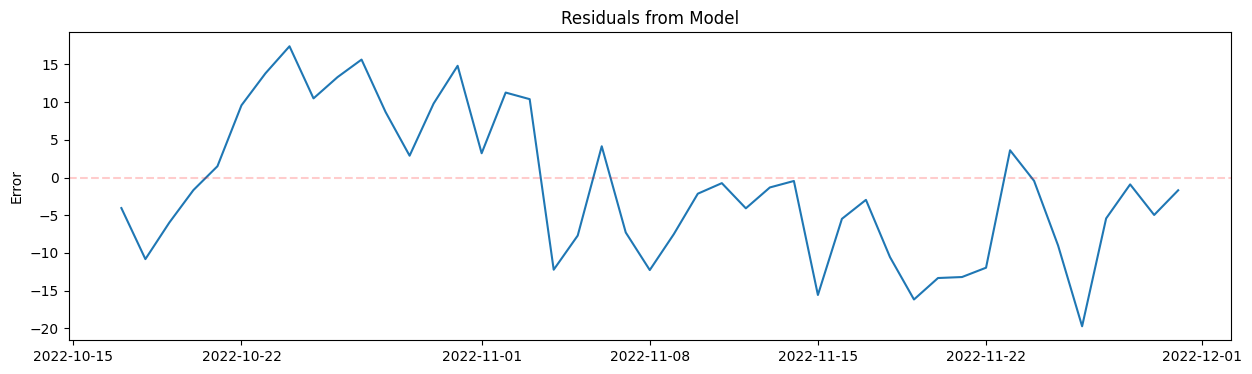

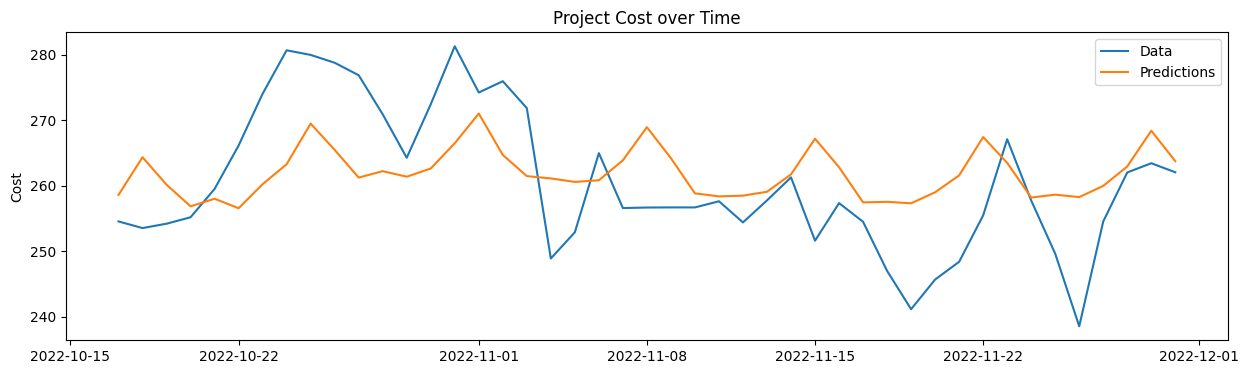

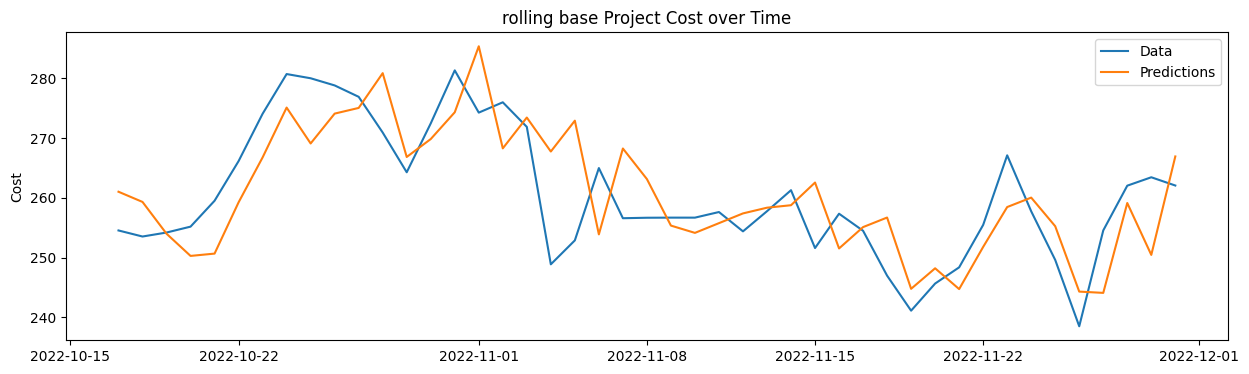

In [ ]:
project = 'a'
model_type = 'sarima'
para = [[1,0,0],[5,1,0,7]] # arima:[[ar, i, ma]], sarima:[[ar, i, ma], [sar, si, sma, s]]
#(1,0,0),(0,1,2,31)11.77
#(1,0,0),(0,1,2,6)11.31
#(3,0,2),(5,1,0,6)9.91
#(3,0,2),(5,1,0,12)9.92
#(1,0,0),(5,1,0,7)8.88

sarima_model('project_a.csv', model_type, para)

In [ ]:
#(3,0,2),(5,1,0,7)6.45
#[2,0,1],[7,1,0,15]5.69

## 自動選出m(週期)，再將m丟進去跑auto_arima輸出最佳參數組合

有進行異常值平滑化之結果

In [ ]:
# 1. 挑windows rmse最低的

df = pd.read_csv('project_a.csv')

# Train and test data

df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df2 = df.copy()

train_end = datetime(2022, 8, 16)
val_end = datetime(2022, 9, 16)
test_end = datetime(2022, 12, 1)
    
train_data = df[:train_end]
val_data = df[train_end+timedelta(days=1):val_end]
test_data = df[val_end+timedelta(days=1):test_end]
prediction = []


window = [45, 60, 75, 90]

for each in window:
    prediction = []
    for i in range(31):
        rolling_train = df[train_end-timedelta(days=each): train_end+timedelta(days=i)]
        pacf_x, confint = pacf(df.cost, nlags=40, alpha=0.05)
        seasonality = None

    

        # Model Training，只在第一次用auto_arima篩出最佳參數
        
        if i == 0:
          if each < 61:
            pacf_x, confint = pacf(rolling_train.cost, nlags=21, alpha=0.05)  # 因為這邊至少要是windows/2，所以我改成21
            seasonality = None
            for k in range(2, 22):
              if abs(confint[k][0]) > 0.23:  # 這個THRESHOLD要依據PACF的帶狀上下限作調整
                  print(abs(confint[k][0]))
                  seasonality = k
                  break
         
    

          print(k)

          Arima_model=auto_arima(rolling_train, start_p=1, max_p=10, max_q=10,max_order = 10, max_P=10, max_Q=5, m=k, seasonal=True, trace=True, d=0, D=1 ,max_d = 2, max_D = 2,error_action='warn', suppress_warnings=True, random_state = 20, n_fits=20)
          para = Arima_model.get_params()
          print(para)
          param1 = para['order'][0]  
          param2 = para['order'][1]  
          param3 = para['order'][2]  
          param4 = para['seasonal_order'][0] 
          param5 = para['seasonal_order'][1]  
          param6 = para['seasonal_order'][2]  
          param7 = para['seasonal_order'][3]  
        # Prediction
        # Prediction
        model = SARIMAX(rolling_train, order=(param1, param2, param3), seasonal_order=(param4, param5, param6, param7))
        model_fit = model.fit()

        pred = model_fit.forecast()
        prediction.append(pred[0])

    print("-------------------------------------------",each,"--------------------------------------------------------------------")
    
    # Model Evaluation
    from sklearn.metrics import mean_squared_error as MSE
    rmse = np.sqrt(MSE(val_data.cost, prediction))
    print(each, "RMSE: %f" %(rmse))


0.2594170088505847
3
Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,1,1)[3] intercept   : AIC=367.932, Time=0.37 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=377.860, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=363.748, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=365.131, Time=0.10 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=376.191, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=371.234, Time=0.08 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=365.742, Time=0.14 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=365.572, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[3] intercept   : AIC=363.616, Time=0.06 sec
 ARIMA(1,0,0)(0,1,2)[3] intercept   : AIC=365.479, Time=0.08 sec
 ARIMA(1,0,0)(1,1,2)[3] intercept   : AIC=365.970, Time=0.12 sec
 ARIMA(0,0,0)(0,1,1)[3] intercept   : AIC=373.179, Time=0.04 sec
 ARIMA(2,0,0)(0,1,1)[3] intercept   : AIC=365.549, Time=0.10 sec
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=365.550, Time=0.07 sec
 ARIMA(2,0,1)(0,1,1)[3] in

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: Valu

------------------------------------------- 45 --------------------------------------------------------------------
45 RMSE: 17.419068
0.23760438024251596
2
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[2] intercept   : AIC=551.131, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[2] intercept   : AIC=573.677, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[2] intercept   : AIC=563.317, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[2] intercept   : AIC=547.180, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[2]             : AIC=571.768, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[2] intercept   : AIC=568.857, Time=0.03 sec
 ARIMA(0,0,1)(1,1,1)[2] intercept   : AIC=549.132, Time=0.15 sec
 ARIMA(0,0,1)(0,1,2)[2] intercept   : AIC=549.128, Time=0.18 sec
 ARIMA(0,0,1)(1,1,0)[2] intercept   : AIC=562.313, Time=0.08 sec
 ARIMA(0,0,1)(1,1,2)[2] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,0,0)(0,1,1)[2] intercept   : AIC=547.782, Time=0.03 sec
 ARIMA(1,0,1)(0,1,1)[2] intercept   : AIC=549.132, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[2] 

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequen

------------------------------------------- 60 --------------------------------------------------------------------
60 RMSE: 18.457539
0.2418110586572313
3
Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,1,1)[3] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=699.747, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=680.412, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=697.834, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=698.945, Time=0.06 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=678.334, Time=0.10 sec
 ARIMA(1,0,0)(3,1,0)[3] intercept   : AIC=675.546, Time=0.14 sec
 ARIMA(1,0,0)(4,1,0)[3] intercept   : AIC=676.149, Time=0.24 sec
 ARIMA(1,0,0)(3,1,1)[3] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(4,1,1)[3] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(3,1,0)[3] intercept   : AIC

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: Valu

------------------------------------------- 75 --------------------------------------------------------------------
75 RMSE: 10.322261
0.23000845076574977
5
Performing stepwise search to minimize aic
 ARIMA(1,0,2)(1,1,1)[5] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=817.765, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=793.664, Time=0.10 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=815.769, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=814.989, Time=0.04 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=789.491, Time=0.15 sec
 ARIMA(1,0,0)(3,1,0)[5] intercept   : AIC=784.105, Time=0.31 sec
 ARIMA(1,0,0)(4,1,0)[5] intercept   : AIC=785.013, Time=0.39 sec
 ARIMA(1,0,0)(3,1,1)[5] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(4,1,1)[5] intercept   : AIC=inf, Time=0.94 sec
 ARIMA(0,0,0)(3,1,0)[5] intercept   : AI

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimizatio

------------------------------------------- 90 --------------------------------------------------------------------
90 RMSE: 8.839502


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


用前80天的資料來預測10/15後的天資料

In [8]:
# 處理異常值
df = pd.read_csv('project_a.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df2 = df.copy()

rolling_deviations = pd.Series(dtype=float, index = df.index)
rolling_deviations_fake = pd.Series(dtype=float, index = df.index)
for date in rolling_deviations.index:
    #get the window ending at this data point
    window = df2.loc[date - timedelta(days=5):date]


    #get the deviation within this window
    rolling_deviations[date] = window.std()
    if rolling_deviations[date] > 20:
          df2.loc[date] = np.mean(df2.loc[date - timedelta(days=5):date])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

In [15]:

# Train and test data
prediction = []
train_end = datetime(2022, 10, 15)
test_end = datetime(2022, 12, 1)
    
train_data = df2[:train_end]
test_data = df[train_end+timedelta(days=1):test_end]

for i in range(len(test_data)):
    rolling_train = df2[train_end-timedelta(days=80): train_end+timedelta(days=i)]


        # Model Training，只在第一次用auto_arima篩出最佳參數
        
    if i % 15 == 0:
        pacf_x, confint = pacf(rolling_train.cost, nlags=35, alpha=0.05)
        seasonality = None
        print(confint)
    
        for k in range(3, 32):
            if abs(confint[k][0]) > 0.3:
                seasonality = k
                break
              

        Arima_model=auto_arima(rolling_train, start_p=1, max_p=10, max_q=10,max_order = 10, max_P=10, max_Q=5, m=k, seasonal=True, trace=True, d=0, D=1 ,max_d = 2, max_D = 2,error_action='warn', suppress_warnings=True, random_state = 20, n_fits=15)
        para = Arima_model.get_params()
        print(para)
        param1 = para['order'][0]  
        param2 = para['order'][1]  
        param3 = para['order'][2]  
        param4 = para['seasonal_order'][0] 
        param5 = para['seasonal_order'][1]  
        param6 = para['seasonal_order'][2]  
        param7 = para['seasonal_order'][3]  
        # Prediction
    model = SARIMAX(rolling_train, order=(param1, param2, param3), seasonal_order=(param4, param5, param6, param7))
    model_fit = model.fit()

    pred = model_fit.forecast()
    print(pred[0])

    prediction.append(pred[0])

rmse = np.sqrt(MSE(test_data.cost, prediction))
print("RMSE: %f" %(rmse))



[[ 1.00000000e+00  1.00000000e+00]
 [ 5.66533973e-01  1.00208152e+00]
 [-4.34564948e-01  9.82604571e-04]
 [-7.61523468e-02  3.59395205e-01]
 [-2.23210587e-01  2.12336965e-01]
 [-5.49133601e-02  3.80634192e-01]
 [-2.96587560e-01  1.38959992e-01]
 [-3.66327292e-01  6.92202600e-02]
 [-4.42492190e-01 -6.94463759e-03]
 [-3.51634613e-01  8.39129390e-02]
 [-5.98389431e-01 -1.62841879e-01]
 [-2.43087401e-01  1.92460151e-01]
 [-4.23586776e-01  1.19607758e-02]
 [-2.63002102e-01  1.72545450e-01]
 [-3.15461538e-01  1.20086014e-01]
 [-4.70514597e-01 -3.49670451e-02]
 [-4.75826054e-01 -4.02785022e-02]
 [-3.45055961e-01  9.04915916e-02]
 [-3.29258899e-01  1.06288653e-01]
 [-1.43242810e-01  2.92304742e-01]
 [-2.54073495e-01  1.81474057e-01]
 [ 2.13559840e-02  4.56903536e-01]
 [-2.45127559e-01  1.90419993e-01]
 [-2.59653202e-01  1.75894350e-01]
 [-4.11966921e-01  2.35806315e-02]
 [-2.64472218e-01  1.71075334e-01]
 [-3.10233146e-01  1.25314406e-01]
 [ 4.54591475e-02  4.81006700e-01]
 [-1.60915941e-01  2

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


254.30285915515586


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


260.60600623431714


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


268.50599118865955


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


268.70973032425206


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


263.9243482940031


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


259.31765139760955


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


258.03104719885374


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


273.7233569589886


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


274.7614553129836


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


282.9761711246372


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


276.8194101909672


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


280.8727873805067


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


269.33352390326127


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


260.8293768051219


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


271.6594994228752
[[ 1.00000000e+00  1.00000000e+00]
 [ 5.99130892e-01  9.99206865e-01]
 [-4.09073507e-01 -8.99753402e-03]
 [-8.22466071e-02  3.17829366e-01]
 [-2.41148159e-01  1.58927814e-01]
 [-5.79892436e-02  3.42086729e-01]
 [-2.80197708e-01  1.19878265e-01]
 [-3.56521651e-01  4.35543220e-02]
 [-4.09501095e-01 -9.42512182e-03]
 [-3.12143560e-01  8.79324134e-02]
 [-5.10460348e-01 -1.10384375e-01]
 [-1.74245907e-01  2.25830066e-01]
 [-3.37224564e-01  6.28514086e-02]
 [-2.70742948e-01  1.29333025e-01]
 [-2.80884813e-01  1.19191160e-01]
 [-4.63036429e-01 -6.29604556e-02]
 [-4.59371185e-01 -5.92952120e-02]
 [-3.88989979e-01  1.10859939e-02]
 [-2.71379501e-01  1.28696472e-01]
 [-2.67756542e-01  1.32319431e-01]
 [-3.15008259e-01  8.50677140e-02]
 [-1.38048881e-01  2.62027092e-01]
 [-3.18607604e-01  8.14683690e-02]
 [-3.74637229e-01  2.54387439e-02]
 [-3.56028026e-01  4.40479473e-02]
 [-3.23809742e-01  7.62662309e-02]
 [-2.07382809e-01  1.92693164e-01]
 [ 1.04676168e-01  5.04752141e-01]
 [

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


276.2182092412014


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


273.38568936771776


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


272.12844220359824


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


272.0267310741673


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


265.30699420955875


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


243.00373349213385


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


261.8425008506122


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


263.8994055650236


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


255.1614968871862


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


261.1664855077959


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


250.04213780998805


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


256.11907819292486


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


256.68906781063265


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


258.43678050794483


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


256.8588662835378
[[ 1.          1.        ]
 [ 0.60158403  0.97364713]
 [-0.39242571 -0.02036261]
 [-0.02123289  0.35083021]
 [-0.28364576  0.08841734]
 [ 0.01028662  0.38234972]
 [-0.25859241  0.11347068]
 [-0.32894157  0.04312153]
 [-0.41897633 -0.04691323]
 [-0.31982947  0.05223363]
 [-0.51888176 -0.14681866]
 [-0.20796378  0.16409932]
 [-0.38667629 -0.01461319]
 [-0.21827524  0.15378786]
 [-0.29506369  0.07699941]
 [-0.39206452 -0.02000143]
 [-0.43683362 -0.06477052]
 [-0.33913617  0.03292693]
 [-0.28852534  0.08353776]
 [-0.17468348  0.19737962]
 [-0.32964     0.04242309]
 [-0.09003572  0.28202737]
 [-0.33202181  0.04004128]
 [-0.35697357  0.01508953]
 [-0.37696825 -0.00490515]
 [-0.21313451  0.15892858]
 [-0.36696258  0.00510052]
 [ 0.03569309  0.40775619]
 [-0.20428633  0.16777677]
 [-0.07499494  0.29706815]
 [-0.0139533   0.3581098 ]
 [-0.0500647   0.3219984 ]
 [-0.38465279 -0.01258969]
 [ 0.02740792  0.39947101]
 [-0.20385165  0.16821145]
 [-0.05351029  0.31855281]]
Performin

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


263.7066032491453


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


252.97350470235142


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


258.40799520010347


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


254.8113778093888


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


248.183716926143


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


248.8537455438729


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


255.73583924488855


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


252.44016102886897


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


261.07402503846913


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


264.26468781338315


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


256.29432270672163


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


248.7218751397387


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


247.4188991046196


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimiz

265.39689180814935


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


262.4872962408525
[[ 1.          1.        ]
 [ 0.61003799  0.95925293]
 [-0.37700758 -0.02779264]
 [-0.01442994  0.334785  ]
 [-0.21184385  0.13737109]
 [ 0.0066289   0.35584384]
 [-0.19740408  0.15181086]
 [-0.31406137  0.03515357]
 [-0.38161547 -0.03240053]
 [-0.29029264  0.0589223 ]
 [-0.43566288 -0.08644794]
 [-0.1957196   0.15349534]
 [-0.38002264 -0.0308077 ]
 [-0.150992    0.19822294]
 [-0.2168851   0.13232984]
 [-0.35346486 -0.00424992]
 [-0.32919584  0.0200191 ]
 [-0.22526697  0.12394797]
 [-0.23548903  0.11372591]
 [-0.07866     0.27055494]
 [-0.18447309  0.16474185]
 [ 0.04040878  0.38962372]
 [-0.27334625  0.07586869]
 [-0.29360351  0.05561142]
 [-0.23203684  0.1171781 ]
 [-0.11673046  0.23248448]
 [-0.19152716  0.15768778]
 [ 0.13402957  0.48324451]
 [-0.10081439  0.24840055]
 [-0.04226147  0.30695347]
 [-0.00561596  0.34359898]
 [-0.11716518  0.23204976]
 [-0.41547234 -0.0662574 ]
 [-0.11060256  0.23861238]
 [-0.3030926   0.04612234]
 [-0.17067482  0.17854012]]
Performin

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


266.60309056294074
RMSE: 6.495783


         date        cost
0  2022-10-16  254.302859
1  2022-10-17  260.606006
2  2022-10-18  268.505991
3  2022-10-19  268.709730
4  2022-10-20  263.924348
5  2022-10-21  259.317651
6  2022-10-22  258.031047
7  2022-10-23  273.723357
8  2022-10-24  274.761455
9  2022-10-25  282.976171
10 2022-10-26  276.819410
11 2022-10-27  280.872787
12 2022-10-28  269.333524
13 2022-10-29  260.829377
14 2022-10-30  271.659499
15 2022-10-31  276.218209
16 2022-11-01  273.385689
17 2022-11-02  272.128442
18 2022-11-03  272.026731
19 2022-11-04  265.306994
20 2022-11-05  243.003733
21 2022-11-06  261.842501
22 2022-11-07  263.899406
23 2022-11-08  255.161497
24 2022-11-09  261.166486
25 2022-11-10  250.042138
26 2022-11-11  256.119078
27 2022-11-12  256.689068
28 2022-11-13  258.436781
29 2022-11-14  256.858866
30 2022-11-15  263.706603
31 2022-11-16  252.973505
32 2022-11-17  258.407995
33 2022-11-18  254.811378
34 2022-11-19  248.183717
35 2022-11-20  248.853746
36 2022-11-21  255.735839
37 2022-11-2

Text(0, 0.5, 'Cost')

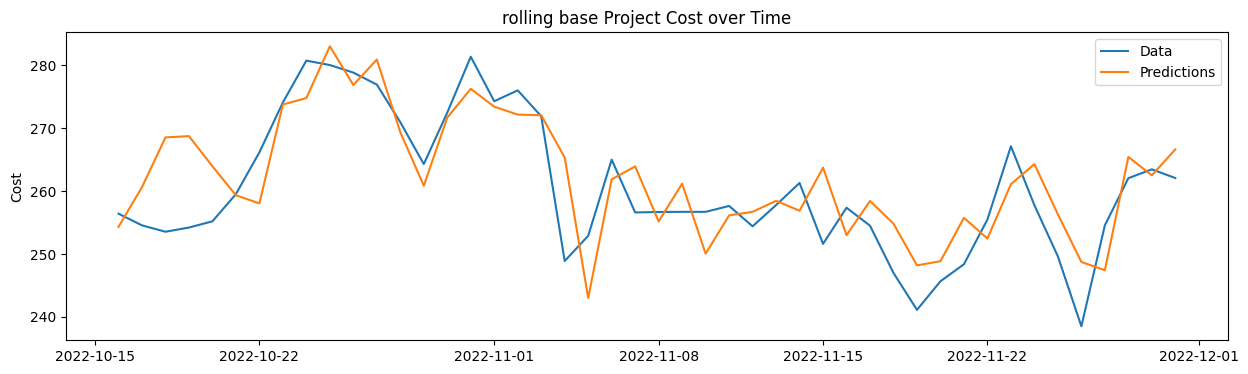

In [16]:
# 建立日期範圍，從 2022/10/16 到 2022/11/30
dates = pd.date_range(start='2022-10-16', end='2022-11-30', freq='D')
dates = pd.to_datetime(dates)
#print(test_data)
# 建立 DataFrame，將預測結果和日期作為列
df = pd.DataFrame({'date': dates, 'cost': prediction})
df['date'] = pd.to_datetime(df['date'])

print(df)

plt.figure(figsize=(15,4))
plt.plot(test_data)
plt.plot(df['date'], df['cost'])

plt.legend(('Data', 'Predictions'))

plt.title('rolling base Project Cost over Time')
plt.ylabel('Cost')


